# `RobustTreeClassifier` Examples

<!-- <font size="3.5">We use a tailored Benders decomposition algorithm to solve this formulation:
</font>


<p align="left">
    <img src="./odtlearn/docs/_static/img/robust_algorithm.png" alt="robust_algorithm" style="width:500px;"/>
</p>  -->

## Example 1: Synthetic Data Without Specified Shifts
If costs and/or budget is not specified, then we will produce the same result as an optimal strong classification tree.

As an example, say that we are given this training set:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

"""
    X2
    |               |
    |               |
    1    + +        |    -
    |               |   
    |---------------|-------------
    |               |
    0    - - - -    |    + + +
    |    - - -      |
    |______0________|_______1_______X1
"""
X = np.array(
    [
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 1],
        [0, 1],
        [0, 1],
    ]
)
X = pd.DataFrame(X, columns=["X1", "X2"])

y = np.array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1])

If either `costs` or `budget` is not specified, the optimal classification tree will be produced (i.e., a tree that does not account for distribution shifts).

In [2]:
from odtlearn.robust_oct import RobustOCT
 
robust_classifier = RobustOCT(
        depth = 2, 
        time_limit = 60
    )
robust_classifier.fit(X, y)
predictions = robust_classifier.predict(X)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-21


In [3]:
robust_classifier.print_tree()

#########node  1
Feature:  X2 , Cutoff:  0
#########node  2
Feature:  X1 , Cutoff:  0
#########node  3
Feature:  X1 , Cutoff:  0
#########node  4
leaf 0
#########node  5
leaf 1
#########node  6
leaf 1
#########node  7
leaf 0


<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


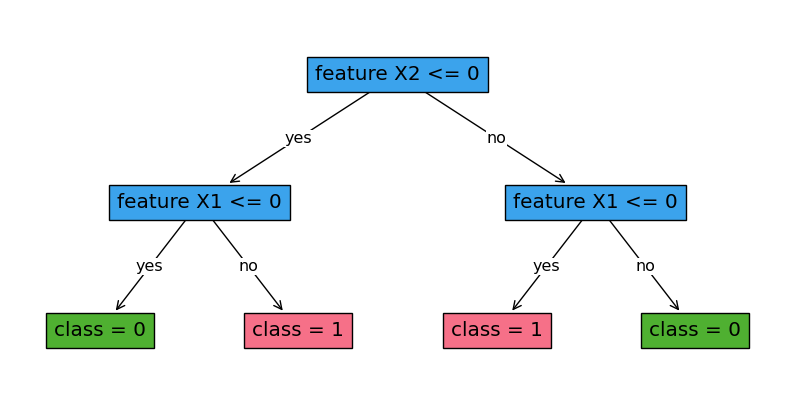

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
robust_classifier.plot_tree()
plt.show()

## Example 2: synthetic data with specified shifts

We take the same synthetic data from Example 1, but now add distribution shifts with the following schema:
- For 5 samples at $[0,0]$, pay a cost of 1 to perturb $X_1$ and get $[1,0]$
- For the 1 sample at $[1,1]$, pay a cost of 1 to perturb $X_2$ to get $[1,0]$
- All other perturbations are not allowed

First, define these costs, which have the same shape and features as your input sample.

In [5]:
# Note: 10 is a proxy for infinite cost, as it is over the allowed budgets we will specify
costs = np.array([[1,10],[1,10],[1,10],[1,10],[1,10],[10,10],[10,10],
                  [10,10],[10,10],[10,10],
                  [10,1],
                  [10,10],[10,10]])
costs = pd.DataFrame(costs, columns=['X1', 'X2'])

<!-- When the budget is 2 (corresponding to the variable &epsilon;), we don't see a change in the tree as the non-robust tree will have worst-case accuracy 11/13 and no other tree will have a better worst-case accuracy. -->
When the budget is 2 (corresponding to the variable &epsilon;), we don't see a change in the tree from Example 1 since for this dataset, the budget is small and thus the level of robustness is small.

In [6]:
# Same data as Example 1
X = np.array(
    [
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 1],
        [0, 1],
        [0, 1],
    ]
)
X = pd.DataFrame(X, columns=["X1", "X2"])

y = np.array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1])

robust_classifier = RobustOCT(
    depth=2,
    time_limit=60,
)
robust_classifier.fit(X, y, costs=costs, budget=2)
predictions = robust_classifier.predict(X)

In [7]:
robust_classifier.print_tree()

#########node  1
Feature:  X2 , Cutoff:  0
#########node  2
Feature:  X1 , Cutoff:  0
#########node  3
Feature:  X1 , Cutoff:  0
#########node  4
leaf 0
#########node  5
leaf 1
#########node  6
leaf 1
#########node  7
leaf 0


<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


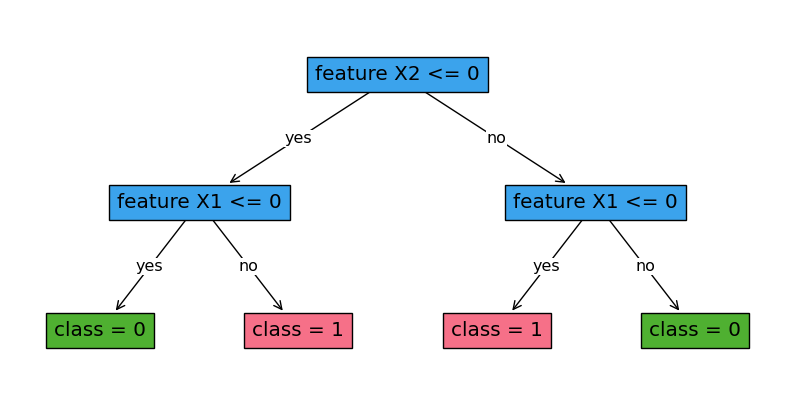

In [8]:
fig, ax = plt.subplots(figsize=(10, 5)) 
robust_classifier.plot_tree()
plt.show()

<!-- <font size="3.5">But when the budget is &epsilon;=5, we see a change in the tree, as we allow up to 5 points at [0,0] and [1,1] to switch to [1,0] to potentially be misclassified. With the non-robust tree, this would decrease our accuracy to 8/13 in worst-case.
    </font>
    
<font size="3.5">If we think it through, the expected tree will classify points at [0,1] as 1, and classify all else as 0, as the allowed perturbations will not change the assigned label, making the worst-case accuracy 10/13 (the maximum worst-case accuracy)
    </font> -->

But when the budget is increased to 5 (adding more robustness), we see a change in the tree.

In [9]:
robust_classifier.fit(X, y, costs=costs, budget=5)
predictions = robust_classifier.predict(X)

In [10]:
robust_classifier.print_tree()

#########node  1
Feature:  X2 , Cutoff:  0
#########node  2
leaf 0
#########node  3
Feature:  X1 , Cutoff:  0
#########node  4
pruned
#########node  5
pruned
#########node  6
leaf 1
#########node  7
leaf 0


<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


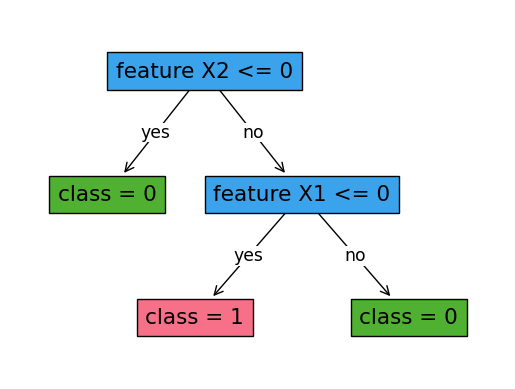

In [11]:
robust_classifier.plot_tree()

## Example 3: UCI data example
Here, we'll see the benefits of using robust optimization by perturbing the test set. We will use the MONK's Problems dataset from the UCI Machine Learning Repository.




In [12]:
from sklearn.model_selection import train_test_split
from odtlearn.datasets import robust_example

Fetch data and split to train and test

In [13]:
"""Fetch data and split to train and test"""
data, y = robust_example()

X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.25, random_state=2
)

For sake of comparison, train a classification tree that does not consider the scenario where there is a distribution shift:

In [14]:
"""Train a non-robust tree for comparison"""
from odtlearn.robust_oct import RobustOCT

# If you define no uncertainty, you get an optimal tree without regularization that maximizes accuracy
non_robust_classifier = RobustOCT(depth=2, time_limit=60, verbose=False)

non_robust_classifier.fit(X_train, y_train)

RobustOCT(depth=2,time_limit=60,num_threads=None,verbose=False)

In [15]:
non_robust_classifier.print_tree()

#########node  1
Feature:  Feat1 , Cutoff:  2
#########node  2
Feature:  Feat0 , Cutoff:  2
#########node  3
Feature:  Feat3 , Cutoff:  2
#########node  4
leaf 0
#########node  5
leaf 1
#########node  6
leaf 0
#########node  7
leaf 1


<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


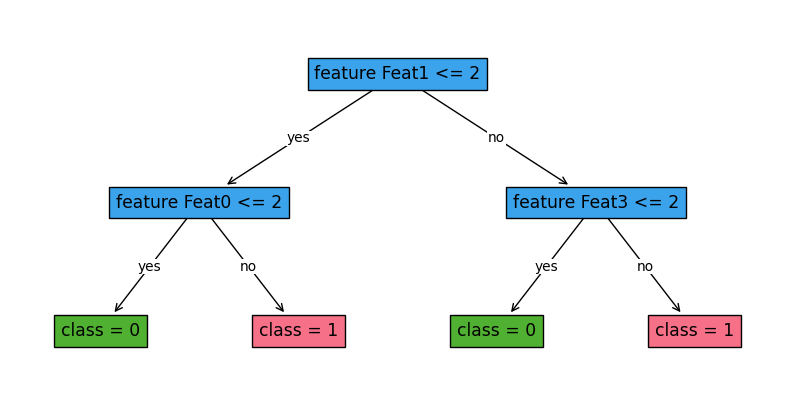

In [16]:
fig, ax = plt.subplots(figsize=(10, 5)) 
non_robust_classifier.plot_tree()
plt.show()

Train a robust tree. First, define the uncertainty. Here, we will generate a probability of certainty for each feature randomly (in practice, you would need to use some guess from domain knowledge). For simplicity, we will not change this probability by data sample $i$. We also define $\lambda = 0.9$, which in practice must be tuned.


In [17]:
"""Generate q_f values for each feature (i.e. probability of certainty for feature f)"""
np.random.seed(42)
q_f = np.random.normal(loc=0.9, scale=0.1, size=len(X_train.columns))
# Snap q_f to range [0,1]
q_f[q_f <= 0] = np.nextafter(np.float32(0), np.float32(1))
q_f[q_f > 1] = 1.0

q_f

array([0.94967142, 0.88617357, 0.96476885, 1.        , 0.87658466,
       0.8765863 ])

Calibrate the `costs` and `budget` parameters for the `fit` function.

In [18]:
"""Define budget of uncertainty"""
from math import log

l = 0.9  # Lambda value between 0 and 1
budget = -1 * X_train.shape[0] * log(l)
budget

13.275424972886112

In [19]:
"""Based on q_f values, create costs of uncertainty"""
from copy import deepcopy

costs = deepcopy(X_train)
costs = costs.astype("float")
for f in range(len(q_f)):
    if q_f[f] == 1:
        costs[costs.columns[f]] = budget + 1  # no uncertainty = "infinite" cost
    else:
        costs[costs.columns[f]] = -1 * log(1 - q_f[f])

costs

,Feat0,Feat1,Feat2,Feat3,Feat4,Feat5
0,2.989182,2.173081,3.345825,14.275425,2.0922,2.092213
1,2.989182,2.173081,3.345825,14.275425,2.0922,2.092213
2,2.989182,2.173081,3.345825,14.275425,2.0922,2.092213
3,2.989182,2.173081,3.345825,14.275425,2.0922,2.092213
4,2.989182,2.173081,3.345825,14.275425,2.0922,2.092213
...,...,...,...,...,...,...
121,2.989182,2.173081,3.345825,14.275425,2.0922,2.092213
122,2.989182,2.173081,3.345825,14.275425,2.0922,2.092213
123,2.989182,2.173081,3.345825,14.275425,2.0922,2.092213
124,2.989182,2.173081,3.345825,14.275425,2.0922,2.092213


Train the robust tree using the costs and budget.

In [20]:
robust_classifier = RobustOCT(
    depth=2,
    time_limit=120,
)
robust_classifier.fit(X_train, y_train, costs=costs, budget=budget)

RobustOCT(depth=2,time_limit=120,num_threads=None,verbose=False)

In [21]:
robust_classifier.print_tree()

#########node  1
Feature:  Feat3 , Cutoff:  2
#########node  2
leaf 0
#########node  3
Feature:  Feat2 , Cutoff:  1
#########node  4
pruned
#########node  5
pruned
#########node  6
leaf 1
#########node  7
leaf 0


<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


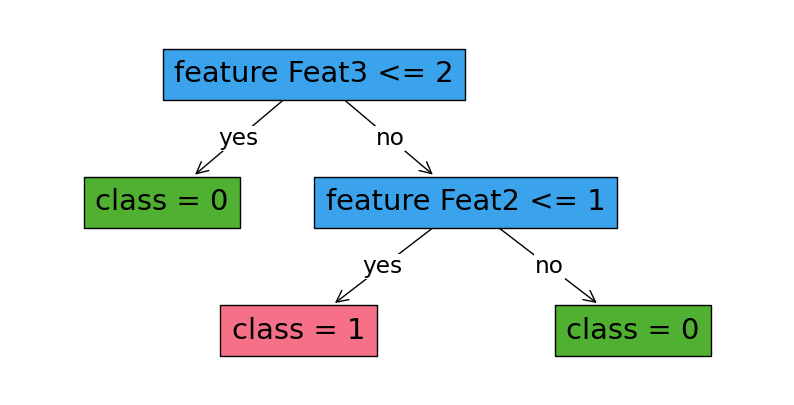

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
robust_classifier.plot_tree()
plt.show()

In [23]:
from sklearn.metrics import accuracy_score

print(
    "Non-robust training accuracy: ",
    accuracy_score(y_train, non_robust_classifier.predict(X_train)),
)
print(
    "Robust training accuracy:     ",
    accuracy_score(y_train, robust_classifier.predict(X_train)),
)
print(
    "Non-robust test accuracy:     ",
    accuracy_score(y_test, non_robust_classifier.predict(X_test)),
)
print(
    "Robust test accuracy:         ",
    accuracy_score(y_test, robust_classifier.predict(X_test)),
)

Non-robust training accuracy:  0.6666666666666666
Robust training accuracy:      0.6587301587301587
Non-robust test accuracy:      0.46511627906976744
Robust test accuracy:          0.5581395348837209


To measure the performance of the trained models, perturb the test data based off of our known certainties of each feature (to simulate a distribtion shift), and then see how well each tree performs against the perturbed data


In [24]:
def perturb(data, q_f, seed):
    """Perturb X given q_f based off of the symmetric geometric distribution"""
    new_data = deepcopy(data)
    np.random.seed(seed)
    # Perturbation of features
    for f in range(len(new_data.columns)):
        perturbations = np.random.geometric(q_f[f], size=new_data.shape[0])
        perturbations = perturbations - 1  # Support should be 0,1,2,...
        signs = (2 * np.random.binomial(1, 0.5, size=new_data.shape[0])) - 1
        perturbations = perturbations * signs
        new_data[new_data.columns[f]] = new_data[new_data.columns[f]] + perturbations
    return new_data


"""Obtain 1000 different perturbed test sets, and record accuracies"""
non_robust_acc = []
robust_acc = []
for s in range(1, 1001):
    X_test_perturbed = perturb(X_test, q_f, s)
    non_robust_pred = non_robust_classifier.predict(X_test_perturbed)
    robust_pred = robust_classifier.predict(X_test_perturbed)
    non_robust_acc += [accuracy_score(y_test, non_robust_pred)]
    robust_acc += [accuracy_score(y_test, robust_pred)]

In [25]:
print("Worst-case accuracy (Non-Robust Tree): ", min(non_robust_acc))
print("Worst-case accuracy (Robust Tree):     ", min(robust_acc))
print(
    "Average accuracy (Non-Robust Tree):    ", sum(non_robust_acc) / len(non_robust_acc)
)
print("Average accuracy (Robust Tree):        ", sum(robust_acc) / len(robust_acc))

Worst-case accuracy (Non-Robust Tree):  0.3953488372093023
Worst-case accuracy (Robust Tree):      0.5116279069767442
Average accuracy (Non-Robust Tree):     0.47367441860465515
Average accuracy (Robust Tree):         0.5584186046511533


## References
* Justin, N., Aghaei, S., Gómez, A., & Vayanos, P. (2022). Optimal robust classification trees. *The AAAI-2022 Workshop on Adversarial Machine Learning and Beyond*. https://openreview.net/pdf?id=HbasA9ysA3
* Dua, D. and Graff, C. (2019). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.